In [3]:
from src.data.diabetes_datasets.data_loader import get_loader
from datetime import datetime

loader = get_loader(
    data_source_name="kaggle_brisT1D", dataset_type="train", use_cached=True
)

2025-11-19T23:03:02 - ============================================================
2025-11-19T23:03:02 - Beginning data loading process with the following parmeters:
2025-11-19T23:03:02 - 	Dataset: kaggle_brisT1D - train
2025-11-19T23:03:02 - 	Columns: None
2025-11-19T23:03:02 - 	Generic patient start date: 2024-01-01 00:00:00
2025-11-19T23:03:02 - 	Number of validation days: 20
2025-11-19T23:03:02 - 	In parallel with up to 3 workers.

2025-11-19T23:03:03 - Loaded full processed data from cache for 9 patients
2025-11-19T23:03:03 - Loaded existing train/validation split from cache for 9 patients


## Configuration

In [4]:
from src.data.models import ColumnNames

INTERVAL_MINS = 5
# https://auto.gluon.ai/dev/tutorials/timeseries/forecasting-chronos.html
# Prediction length: 8 hours ahead
PREDICTION_HOURS = 8

INTERVAL_MINS = 5
TRAIN_HOURS = 40
PREDICTION_HOURS = 8

prediction_length = int((PREDICTION_HOURS * 60) / INTERVAL_MINS)
context_length = int(TRAIN_HOURS * 60 / INTERVAL_MINS)

EXOG_COLS = [
    ColumnNames.DOSE_UNITS.value,
    ColumnNames.FOOD_G.value,
    ColumnNames.COB.value,
    ColumnNames.CARB_AVAILABILITY.value,
    ColumnNames.IOB.value,
    ColumnNames.INSULIN_AVAILABILITY.value,
]

### Prepare data for AutoGluon

run `pip install autogluon`

In [5]:
import pandas as pd
from src.utils.time_series_helper import get_interval_minutes
from autogluon.timeseries import TimeSeriesDataFrame
from src.data.models import ColumnNames


def prepare_data(
    df: dict[str, pd.DataFrame], exog_cols: list[str]
) -> TimeSeriesDataFrame:
    """
    Prepare data for AutoGluon
    Args:
        df: dict[str, pd.DataFrame]
            Dictionary of patient IDs and their data
        exog_cols: list[str]
            List of exogenous variables
    Returns:
        TimeSeriesDataFrame
    """
    train_data_list = []
    for patient_id, patient_df in df.items():
        target_col = ColumnNames.BG.value
        if get_interval_minutes(patient_df) != INTERVAL_MINS:
            continue

        # Ensure datetime index
        if not isinstance(patient_df.index, pd.DatetimeIndex):
            if "datetime" in patient_df.columns:
                patient_df = patient_df.set_index("datetime")
            else:
                raise ValueError(
                    f"Patient {patient_id} data doesn't have datetime index or column"
                )

        if len(patient_df) > 0:
            # Prepare data (exogenous variables + target)
            train_data = patient_df[exog_cols + [target_col]].copy()
            # TimeSeriesDataFrame expects a MultiIndex with 'item_id' and 'timestamp'
            train_data.index = pd.MultiIndex.from_product(
                [[patient_id], train_data.index], names=["item_id", "timestamp"]
            )
            train_data_list.append(train_data)

    # Combine all patients into DataFrames
    glucose_train_df = pd.concat(train_data_list)
    print("  - Original data shape:", glucose_train_df.shape)

    train_df = TimeSeriesDataFrame(glucose_train_df)
    return train_df


# Prepare data for AutoGluon - split into train and validation periods
if (
    loader.train_data is None
    or loader.validation_data is None
    or loader.processed_data is None
):
    raise ValueError("No training data found")

train_df: dict[str, pd.DataFrame] = loader.train_data
val_df: dict[str, pd.DataFrame] = loader.validation_data

train_tsdf = prepare_data(train_df, EXOG_COLS)
holdout_tsdf = prepare_data(val_df, EXOG_COLS)

  - Original data shape: (119816, 7)
  - Original data shape: (34566, 7)


### Output directory

In [6]:
from src.utils.os_helper import get_project_root
from autogluon.timeseries import TimeSeriesPredictor

root = get_project_root()
dataset_name = loader.dataset_name
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
models_dir = root / "models" / "chronos"
output_dir = models_dir / dataset_name / f"{INTERVAL_MINS}min" / timestamp

### Zero-shot settings

In [7]:
train_data, test_data = train_tsdf.train_test_split(prediction_length=prediction_length)

predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target=ColumnNames.BG.value,
    eval_metric="RMSE",
    path=output_dir,
)

predictor.fit(
    train_data,
    hyperparameters={
        "Chronos": {
            "model_path": "amazon/chronos-bolt-small",
            "context_length": context_length,
            # "covariate_regressor": "CAT" -- This is for known_covariates only
        },
    },
)

## Double check the past_covariates in the log has all the exogenous variables (this is inferred from the dataset)
## All columns that is not the target column or known_covariates (exogenous variables during prediction) are past_covariates

Sorting the dataframe index before generating the train/test split.
Beginning AutoGluon training...
AutoGluon will save models to '/Users/tonychan/GlucoseML/nocturnal-hypo-gly-prob-forecast/models/chronos/kaggle_brisT1D/5min/20251119_230310'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.3
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.4.0: Fri Apr 11 18:33:47 PDT 2025; root:xnu-11417.101.15~117/RELEASE_ARM64_T6000
CPU Count:          10
GPU Count:          1
Memory Avail:       5.06 GB / 16.00 GB (31.6%)
Disk Space Avail:   162.42 GB / 926.35 GB (17.5%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': {'Chronos': {'context_length': 480,
                                 'model_path': 'amazon/chronos-bolt-small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 96,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5,

### Plot

In [ ]:
%matplotlib inline
# Predict on train_data (without the last prediction_legnth worth of data)
predictions = predictor.predict(train_data)

predictor.plot(
    data=train_tsdf,  # This is the entire data
    predictions=predictions,
    max_history_length=200,
)

### Eval
All metric are reported in higher is better

RMSE is multiplied by -1 so higher is better

In [92]:
import pandas as pd


def rolling_eval(predictor, data, num_windows, metrics=("RMSE",)):
    rows = []
    for i in range(num_windows):
        cutoff = -(i + 1) * predictor.prediction_length  # -96, -192, ...
        scores = predictor.evaluate(data, cutoff=cutoff, metrics=list(metrics))
        scores["cutoff_steps"] = cutoff
        rows.append(scores)
    to_return = pd.DataFrame(rows)
    print(to_return)
    print("\nAverage RMSE across windows:")
    print(to_return.mean(numeric_only=True).to_dict()["RMSE"])
    return to_return


rolling_scores = rolling_eval(predictor, holdout_tsdf, num_windows=5)

Model not specified in predict, will default to the model with the best validation score: Chronos[amazon__chronos-bolt-small]
Model not specified in predict, will default to the model with the best validation score: Chronos[amazon__chronos-bolt-small]
Model not specified in predict, will default to the model with the best validation score: Chronos[amazon__chronos-bolt-small]
Model not specified in predict, will default to the model with the best validation score: Chronos[amazon__chronos-bolt-small]
Model not specified in predict, will default to the model with the best validation score: Chronos[amazon__chronos-bolt-small]


       RMSE  cutoff_steps
0 -2.573526           -96
1 -2.984588          -192
2 -2.845667          -288
3 -1.932759          -384
4 -2.273919          -480

Average RMSE across windows:
-2.522091844342321


## Fine-tune Settings
Reference: https://auto.gluon.ai/dev/tutorials/timeseries/forecasting-chronos.html#fine-tuning

All Chronos fine-tuning options: https://auto.gluon.ai/dev/tutorials/timeseries/forecasting-model-zoo.html#autogluon.timeseries.models.ChronosModel

Transformer Args: https://huggingface.co/docs/transformers/en/main_classes/trainer

Amazon: https://aws.amazon.com/blogs/machine-learning/fast-and-accurate-zero-shot-forecasting-with-chronos-bolt-and-autogluon/

## Training Flow: AutoGluon + Chronos Fine-Tuning

### Phase 1: AutoGluon Level (Expanding Window Split)
| Component | Data Range |
|-----------|------------|
| train_fold | `[1, ..., N-96]` |
| val_fold | `[N-95, ..., N]` |

### Phase 2: Chronos Level (Random Sliding Windows - Infinite Dataset)

**Note:** ChronosFineTuningDataset is infinite (cycles forever, generates random windows indefinitely)

#### Training Configuration
- `fine_tune_steps = 10,000,000` → `max_steps = 10,000,000`
- `batch_size = 64`

#### Training Process
| Step | Action |
|------|--------|
| Step 1 | Batch 1: 64 random windows → train |
| Step 2 | Batch 2: 64 random windows → train |
| Step 3 | Batch 3: 64 random windows → train |
| ... | ... (continues generating random windows) |
| Step 10,000,000 | Final batch: 64 random windows → train |
| After Step 10,000,000 | Training stops (max_steps reached) |

**Total:** 10,000,000 steps = 10,000,000 batches = 640,000,000 windows (10M × 64)

#### Validation
- Validation occurs based on `eval_strategy` setting (e.g., every N steps or at end)
- Uses `val_fold` (last 96 time steps of each time series)

#### Notes
- Dataset is infinite: keeps generating new random windows forever (an finite tape)
- Training stops at `max_steps` (10M steps), not after 3 epochs
- Random windows are sampled on-the-fly during training by picking a random position on the tape and extract a window of size `context_length` + `prediction_length`
- Each batch contains 64 random windows sampled from `train_fold`


Note on infinite dataset:

https://github.com/Lightning-AI/pytorch-lightning/issues/2150

In [6]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = f"{models_dir}/fine_tune/{timestamp}"

# Resume where it left off???? Need to figure this out. It doesn't work
# output_dir = "models/chronos/fine_tune/20251119_012235"

train_data = prepare_data(loader.train_data, EXOG_COLS)
# This is the holdout set we will be using for model evaluation
test_data = prepare_data(loader.validation_data, EXOG_COLS)


predictor_ft = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target=ColumnNames.BG.value,
    eval_metric="RMSE",
    path=output_dir,
)

predictor_ft.fit(
    train_data=train_data,
    num_val_windows=1,  # Only validate with one window (last prediction_length worth of data)
    hyperparameters={
        "Chronos": [
            # It looks like that the params can be a search space too for grid search
            {
                "model_path": "bolt_small",
                "fine_tune": True,
                "ag_args": {"name_suffix": "FineTuned"},
                "fine_tune_lr": 1e-4,
                "fine_tune_steps": 10000 * 100,
                "device": None,
                "context_length": context_length,
                # "eval_during_fine_tune": True,  # Evaluate the model during fine-tuning
                "fine_tune_trainer_kwargs": {
                    "output_dir": output_dir,
                    "save_strategy": "steps",
                    "save_steps": 10000,
                    "eval_strategy": "steps",
                    "eval_steps": 10000,
                    # "num_train_epochs": 3, # Doesn't make sense in the context of infinite dataset
                    "save_total_limit": 5,
                    "per_device_train_batch_size": 64,
                    "per_device_eval_batch_size": 64,
                },
                "keep_transformers_logs": True,
            },
            # Can fit multiple models at once
        ]
    },
    time_limit=1 * 60 * 60,  # time limit in seconds
    enable_ensemble=False,
)

  - Original data shape: (119816, 7)
  - Original data shape: (34566, 7)


Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'c:\Users\Tony\GlucoseML\nocturnal-hypo-gly-prob-forecast\models\chronos\fine_tune\20251119_151320'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
GPU Count:          1
Memory Avail:       17.17 GB / 31.15 GB (55.1%)
Disk Space Avail:   435.22 GB / 1862.20 GB (23.4%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': RMSE,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'FineTuned'},
                                  'context_length': 480,
                                  'device': None,
                                  'fine_tune': True,
                                  'fine_tune_lr': 0.0001,
                                  'fine_tune_steps': 1000000,
                                  'fine_tune_trainer_kwa

### Evaludation on holdout set: WIP

In [8]:
rolling_scores = rolling_eval(predictor_ft, holdout_tsdf, num_windows=5)
print(rolling_scores)

# All metric are reported in higher is better
# RMSE is multiplied by -1 so higher is better

Model not specified in predict, will default to the model with the best validation score: ChronosFineTuned[bolt_small]
Model not specified in predict, will default to the model with the best validation score: ChronosFineTuned[bolt_small]
Model not specified in predict, will default to the model with the best validation score: ChronosFineTuned[bolt_small]
Model not specified in predict, will default to the model with the best validation score: ChronosFineTuned[bolt_small]
Model not specified in predict, will default to the model with the best validation score: ChronosFineTuned[bolt_small]


       RMSE  cutoff_steps
0 -2.001689           -96
1 -2.737455          -192
2 -2.533252          -288
3 -1.945347          -384
4 -3.206827          -480


### Plot the glucose level and IOB/COB level for a random window from the holdout set

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from src.data.models import ColumnNames


def plot_rolling_prediction(
    predictor: TimeSeriesPredictor,
    data: TimeSeriesDataFrame,
    context_length: int,
    prediction_length: int,
    patient_id=None,
    max_history_length=None,
    random_seed=None,
    show_plot=True,
):
    """
    Perform a rolling prediction on a random window from the test data and plot the results.

    Args:
        predictor: TimeSeriesPredictor instance to use for predictions
        data: TimeSeriesDataFrame containing the test/holdout data
        context_length: Length of context window to use for prediction
        prediction_length: Length of prediction horizon
        patient_id: Optional patient ID to use. If None, randomly selects a patient
        max_history_length: Maximum history length to show in plot. If None, uses context_length
        random_seed: Optional random seed for reproducibility
        show_plot: Whether to display the plot. Default True.

    Returns:
        dict: Dictionary containing:
            - 'patient_id': The patient ID used
            - 'cutoff_timestamp': The cutoff timestamp
            - 'cutoff_idx': The cutoff index
            - 'predictions': The predictions DataFrame
            - 'observed_future': The observed future values
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    if max_history_length is None:
        max_history_length = context_length

    # Select a random patient from test data if not provided
    if patient_id is None:
        test_patient_ids = data.index.get_level_values("item_id").unique()
        patient_id = np.random.choice(test_patient_ids)

    # Get the time series for this patient
    patient_data = data.loc[patient_id]

    # Ensure we have enough data: need at least context_length + prediction_length
    min_required_length = context_length + prediction_length
    if len(patient_data) < min_required_length:
        raise ValueError(
            f"Patient {patient_id} doesn't have enough data. "
            f"Need at least {min_required_length} points, but got {len(patient_data)}."
        )

    # Select a random cutoff point (ensuring we have enough history and future)
    # The cutoff should be at least context_length from the start
    # and at least prediction_length from the end
    max_cutoff_idx = len(patient_data) - prediction_length
    min_cutoff_idx = context_length

    if max_cutoff_idx <= min_cutoff_idx:
        raise ValueError(
            f"Patient {patient_id} doesn't have enough data for rolling prediction. "
            f"Need at least {min_cutoff_idx + prediction_length} points, but got {len(patient_data)}."
        )

    # Random cutoff index
    random_cutoff_idx = np.random.randint(min_cutoff_idx, max_cutoff_idx)
    cutoff_timestamp = patient_data.index[random_cutoff_idx]

    # Create a subset of the test data up to the cutoff point
    # We need to maintain the MultiIndex structure
    # The window will only have exactly context_length worth of data
    test_window = data.loc[patient_id].iloc[
        random_cutoff_idx - context_length : random_cutoff_idx
    ]
    test_window.index = pd.MultiIndex.from_product(
        [[patient_id], test_window.index], names=["item_id", "timestamp"]
    )
    test_window_tsdf = TimeSeriesDataFrame(test_window)

    # Make prediction
    predictions = predictor.predict(test_window_tsdf)

    # Get the actual observed data for the prediction period
    observed_future = data.loc[patient_id].iloc[
        random_cutoff_idx : random_cutoff_idx + prediction_length
    ]

    # Plot using matplotlib for better control
    if show_plot:
        # Get the history data (context)
        history_data = patient_data.iloc[
            random_cutoff_idx - context_length : random_cutoff_idx
        ]

        target_col = predictor.target

        # Check if target_col exists in history_data, if not use first column
        if target_col not in history_data.columns:
            target_col = history_data.columns[0]

        # Extract timestamps and values for glucose
        history_timestamps = history_data.index
        history_values = history_data[target_col].values

        # Get prediction timestamps and values
        pred_timestamps = predictions.loc[patient_id].index

        # Handle predictions - AutoGluon predictions might have different structure
        pred_data = predictions.loc[patient_id]
        if target_col in pred_data.columns:
            pred_values = pred_data[target_col].values
        elif len(pred_data.columns) == 1:
            # If only one column, use that
            pred_values = pred_data.iloc[:, 0].values
        else:
            # Try to find mean or first numeric column
            numeric_cols = pred_data.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                pred_values = pred_data[numeric_cols[0]].values
            else:
                pred_values = pred_data.iloc[:, 0].values

        # Get observed future timestamps and values
        observed_timestamps = observed_future.index
        if target_col in observed_future.columns:
            observed_values = observed_future[target_col].values
        else:
            observed_values = observed_future.iloc[:, 0].values

        # Get IOB and COB data if available
        iob_col = ColumnNames.IOB.value
        cob_col = ColumnNames.COB.value

        has_iob = iob_col in patient_data.columns
        has_cob = cob_col in patient_data.columns

        # Extract IOB and COB values for history and future
        if has_iob:
            history_iob = history_data[iob_col].values
            observed_iob = (
                observed_future[iob_col].values
                if iob_col in observed_future.columns
                else None
            )
        else:
            history_iob = None
            observed_iob = None

        if has_cob:
            history_cob = history_data[cob_col].values
            observed_cob = (
                observed_future[cob_col].values
                if cob_col in observed_future.columns
                else None
            )
        else:
            history_cob = None
            observed_cob = None

        # Create subplots: glucose on top, IOB/COB on bottom
        if has_iob or has_cob:
            fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
            ax1 = axes[0]  # Glucose plot
            ax2 = axes[1]  # IOB/COB plot
        else:
            fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
            ax2 = None

        # Plot glucose on first subplot
        ax1.plot(
            history_timestamps,
            history_values,
            label="History (Context)",
            color="blue",
            linewidth=1,
            alpha=0.7,
        )
        ax1.plot(
            observed_timestamps,
            observed_values,
            label="Observed (Future)",
            color="green",
            linestyle="--",
            linewidth=0.7,
            marker="o",
            markersize=2,
        )
        ax1.plot(
            pred_timestamps,
            pred_values,
            label="Predicted",
            color="red",
            linewidth=0.7,
            marker="s",
            markersize=2,
        )
        ax1.axvline(
            x=cutoff_timestamp,
            color="gray",
            linestyle=":",
            linewidth=1.5,
            alpha=0.7,
            label="Cutoff",
        )
        ax1.set_ylabel(f"{target_col} (mmol/L)", fontsize=12)
        ax1.set_title(
            f"Rolling Prediction for Patient {patient_id}\n"
            f"Cutoff: {cutoff_timestamp}",
            fontsize=14,
        )
        ax1.legend(loc="best", fontsize=10)
        ax1.grid(True, alpha=0.3)

        # Plot IOB and COB on second subplot if available
        if ax2 is not None:
            if has_iob:
                ax2.plot(
                    history_timestamps,
                    history_iob,
                    label="IOB (History)",
                    color="orange",
                    linewidth=1,
                    alpha=0.7,
                )
                if observed_iob is not None:
                    ax2.plot(
                        observed_timestamps,
                        observed_iob,
                        label="IOB (Future)",
                        color="orange",
                        linestyle="--",
                        linewidth=0.7,
                        marker="o",
                        markersize=2,
                    )

            if has_cob:
                ax2.plot(
                    history_timestamps,
                    history_cob,
                    label="COB (History)",
                    color="purple",
                    linewidth=1,
                    alpha=0.7,
                )
                if observed_cob is not None:
                    ax2.plot(
                        observed_timestamps,
                        observed_cob,
                        label="COB (Future)",
                        color="purple",
                        linestyle="--",
                        linewidth=0.7,
                        marker="o",
                        markersize=2,
                    )

            ax2.axvline(
                x=cutoff_timestamp,
                color="gray",
                linestyle=":",
                linewidth=1.5,
                alpha=0.7,
                label="Cutoff",
            )
            ax2.set_xlabel("Timestamp", fontsize=12)
            ax2.set_ylabel("IOB (units) / COB (g)", fontsize=12)
            ax2.legend(loc="best", fontsize=10)
            ax2.grid(True, alpha=0.3)
        else:
            ax1.set_xlabel("Timestamp", fontsize=12)

        plt.tight_layout()
        plt.show()

    # Print information
    print(f"Patient: {patient_id}")
    print(f"Cutoff timestamp: {cutoff_timestamp}")
    print(f"History length: {random_cutoff_idx}")
    print(f"Prediction length: {prediction_length}")

    return {
        "patient_id": patient_id,
        "cutoff_timestamp": cutoff_timestamp,
        "cutoff_idx": random_cutoff_idx,
        "predictions": predictions,
        "observed_future": observed_future,
    }

Model not specified in predict, will default to the model with the best validation score: Chronos[amazon__chronos-bolt-small]


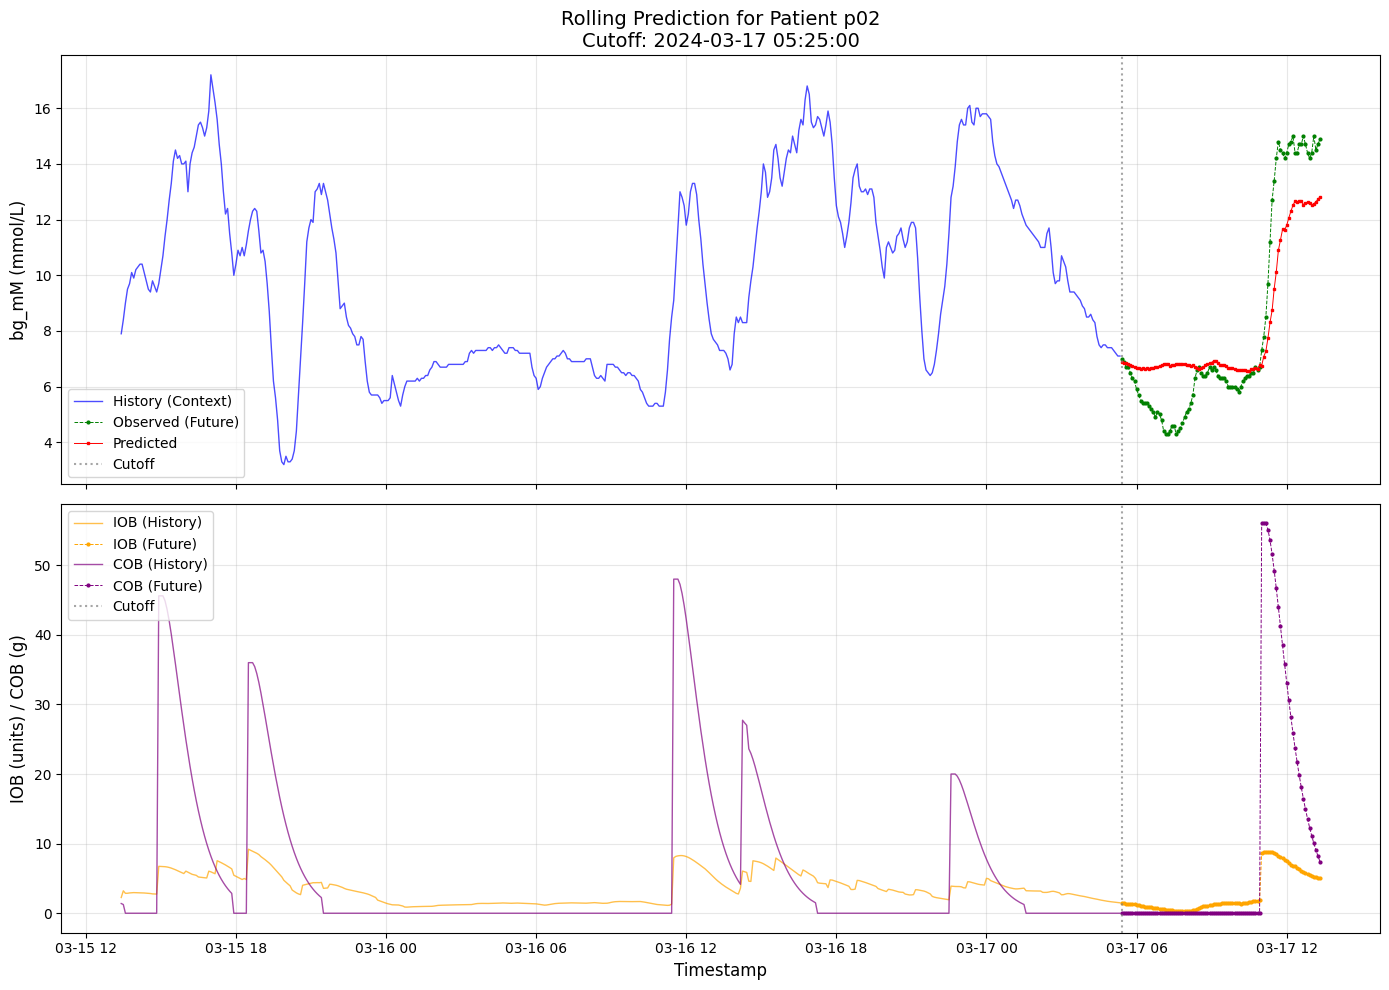

Patient: p02
Cutoff timestamp: 2024-03-17 05:25:00
History length: 1422
Prediction length: 96


In [86]:
result = plot_rolling_prediction(
    predictor=predictor,
    data=holdout_tsdf,
    context_length=context_length,
    prediction_length=prediction_length,
)